## Youssef Abdelmoamen - 190054712

## Setup dependencies

In [2]:
try:
    import google.colab
    import subprocess
    import os.path
    p = subprocess.run(['git', 'rev-parse', '--is-inside-work-tree'], stdout=subprocess.PIPE, universal_newlines=True)
    if p.stdout == 'true\n':
        !git pull
    else:
        if not os.path.isdir('city_dsp_ap'):
            !git clone --depth 1 -q https://github.com/tweyde/city_dsp_ap.git
        %cd city_dsp_ap
except:
    %cd city_dsp_ap

Already up to date.


In [14]:
import numpy as np
from scipy import fft, signal
from scipy.io import wavfile
import matplotlib.pyplot as plt
from skimage.transform import rotate
from skimage.util import random_noise
from IPython.display import Audio, display
import scipy.signal as sig
import soundfile as sf



## Controllable delay line (UG) or filter (PG)

You will need to create a function that applies the desired effect to any input signal, where the effect can be dynamically modified by a control signal. The functions only need to be implemented for offline use, so you don't need to be handle input buffers of arbitrary sizes like in lab 6. It suffices to use a single for loop to run over all samples of the input and control signals, and create the output sample-by-sample.

In both cases, the control signal will be a sine of 2Hz. Create one of the required length yourself. Any signal should work as input signal. You can learn how to [upload your own files](https://colab.research.google.com/notebooks/io.ipynb) into Google Colab, but the easiest will be to use one of the wave files available in the `audio` directory. If you're loading a stereo file, it is allowed to mix it down into a single mono channel before passing it to the effect to simplify processing.

In [4]:
%ls audio/*.wav

audio/20-16000HzExp5sec.wav  audio/carrier.wav*  audio/rockB.wav
audio/20-16000HzLin5sec.wav  audio/rockA.wav


#### UG
Program a controllable delay line. Mix the output with the original input to create a flanging effect. Use the control signal to vary the amount of delay between zero and a maximum value (1 millisecond would be a good default for this, use the samplerate to calculate how much samples this is).

#### PG
Program a controllable FIR filter, i.e. a filter that changes its characteristics over time in response to a control signal. Apply the filter to the signal by implementing a convolution with the filter coefficients in a loop over the samples, just like in lab 7. In order to make the filter respond to the control signal, you can either design two static filters and interpolate between them (like in lab 7), or you can directly manipulate the filter characteristics in the filter design function [`firls`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.firls.html) and call it for every iteration.

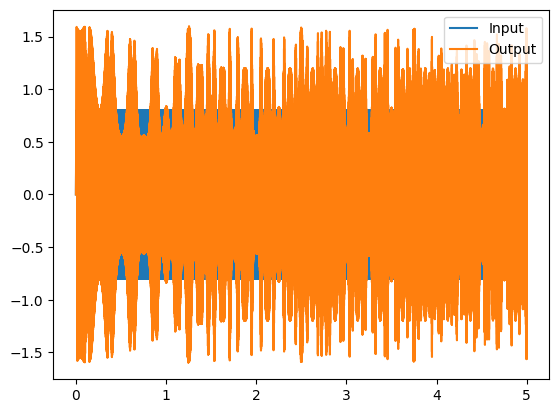

In [56]:
# Define sampling rate and maximum delay time
sampling_rate = 44100 # in Hz
max_delay= 0.001  # 1 millisecond

# Define delay line buffer
delay_length = round(max_delay * sampling_rate) #Calculate the delay line length
delay_buffer = np.zeros(delay_length) 

# Define current delay time
current_delay = 0.0 #Initialize the current delay time to 0.

# Modulate delay time with sine wave
def modulate_delay(amplitude):
    sine_wave = amplitude * np.sin(2*np.pi*2*np.arange(len(delay_buffer))/sampling_rate)
    return sine_wave

# Mix delayed and original signals
def mix_signals(input_signal, delayed_signal, feedback_gain):
    # Compute the output signal as a weighted sum of the input and delayed signals
    # with feedback
    output_signal = input_signal + feedback_gain * delayed_signal
    return output_signal

# Read audio samples and write to output
def process_audio(input_samples, feedback_gain, delay_time_control, delay_time_max):
    global delay_buffer  # declare delay_line_buffer as a global variable
    output_samples = np.zeros(len(input_samples))
    for i, input_sample in enumerate(input_samples):
        # Calculate current delay time
        current_delay_time = delay_time_max * delay_time_control[i]
        
        # Write input sample to delay line buffer
        delay_buffer = np.roll(delay_buffer, 1)
        delay_buffer[0] = input_sample
        
        # Calculate interpolated delay time
        interpolated_delay_time = (1 - delay_time_control[i]) * current_delay_time
        
        # Read delayed sample from delay line buffer
        delayed_sample = np.interp(interpolated_delay_time, np.arange(delay_length), delay_buffer)
        
        # Mix delayed and input signals
        output_samples[i] = mix_signals(input_sample, delayed_sample, feedback_gain)
        
        # Write output sample to delay line buffer
        delay_buffer[0] = output_samples[i]
    
    # Return output samples
    return output_samples

# Load audio file
filename = 'audio/20-16000HzLin5sec.wav'
input_samples, sampling_rate = sf.read(filename)

# Apply delay line with flanging effect
feedback_gain = 0.5
delay_time_control = 0.5 * (1 + np.sin(2*np.pi*2*np.arange(len(input_samples))/sampling_rate)) # modulate delay time using a sinusoid
delay_time_max = max_delay * sampling_rate
y = process_audio(input_samples, feedback_gain, delay_time_control, delay_time_max)

# Write output to file
output_filename = 'output.wav'
sf.write(output_filename, y, sampling_rate)

# Plot input and output signals
p = np.arange(len(input_samples))/sampling_rate
plt.figure()
plt.plot(p, input_samples, label='Input')
plt.plot(p, y, label='Output')
plt.legend()
plt.show()

In [29]:
# Play input audio
display(Audio(input_samples, rate=sampling_rate))

# Play output audio
display(Audio(y, rate=sampling_rate))

## Digit recognition (UG & PG)

In this part, you're going to use images of handwritten digits ranging from 0 to 9. They are split in a training set and a test set and stored as text files in `data/digits-training.txt` and `data/digits-test.txt`.

In [6]:
%ls data/digits-*.txt

data/digits-test.txt*  data/digits-training.txt*


In [7]:
from itertools import islice
import re

def read_digit_pixels_and_labels(path):
    with open(path) as f:
        header = list(islice(f, 21))
        pixel_height = [int(x[1]) for x in map(lambda r: re.match('entheight = (\d+)', r), header) if x][0]
        num_digits = [int(x[1]) for x in map(lambda r: re.match('ntot = (\d+)', r), header) if x][0]
        digit_pixels = []
        labels = []
        for _ in range(num_digits):
            chunk = list(islice(f, pixel_height+1))
            digit_pixels.append(np.loadtxt(chunk[:-1]))
            labels.append(int(chunk[-1]))
    return digit_pixels, labels

Since the text files have a custom format, a loader function `read_digit_pixels_and_labels` is provided.

In [8]:
training_digits, training_labels = read_digit_pixels_and_labels('data/digits-training.txt')
test_digits, test_labels = read_digit_pixels_and_labels('data/digits-test.txt')

In [9]:
len(training_digits), len(training_labels), len(test_digits), len(test_labels)

(1934, 1934, 943, 943)

All digits and their associated labels have now been read into lists, so we can use list indexing to access them and, for instance, display them as below.

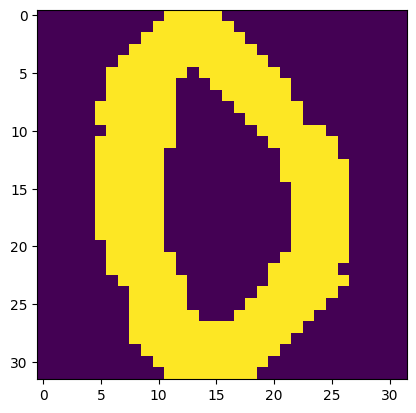

Image of digit 0


In [10]:
index = 1
plt.figure()
plt.imshow(training_digits[index])
plt.show()
print('Image of digit {}'.format(training_labels[index]))

Using this data, your task is to:

1. Create a function for comparing each test image with the collection of training images, using the correlation with each training image without offset (i.e. calculate the sum of the element-wise multiplied images).
2. Estimate the most likely label for each test image by matching with the training image that has maximal correlation.
3. Estimate the accuracy of your system, as a fraction of the correctly estimated test labels over the total number of test images.
4. Use the two-dimensional correlation function [`signal.correlate2d`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate2d.html) to find the best match over all image offsets. For efficiency you can use a subset of the training images, or calculate an average of the training images.
5. Implement variants of the digit recognition system, e.g.
    - use the negatives of the training and test images instead of the positive images
    - use images that are slightly rotated in your training set (using [`rotate`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.rotate) from the `scikit-image.transform` library)
    - use images with some noise added in your training set (using [`random_noise`](https://scikit-image.org/docs/dev/api/skimage.util.html#random-noise) from the `scikit-image.util` library)
6. Report the accuracy of the new system and compare with the accuracy of the previous systems.
7. In the written report, discuss and reason about the different performances of your classifiers.

## Task 1, 2 and 3 will be displayed in the following code box and task 4, 5 and 6 will be diplayed in the following code box


Accuracy (original system): 90.14%


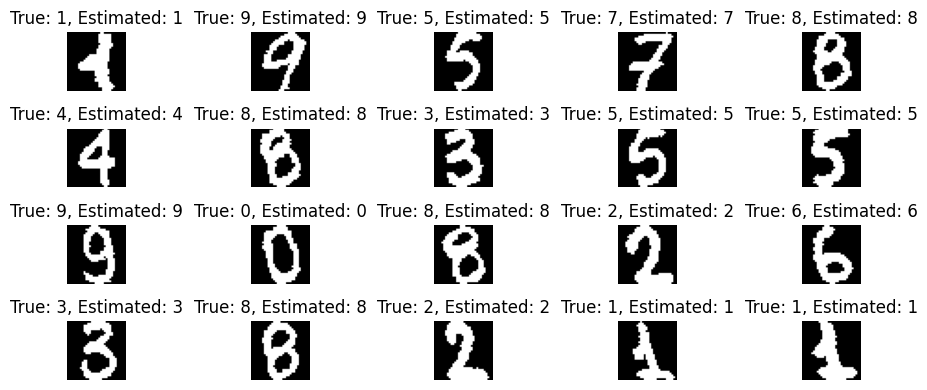

In [45]:
#step 1 (Create a function for comparing each test image with the collection of training images, using the correlation with each training image without offset)
def correlation_matrix(training_digits, test_digits):
    c_matrix = np.zeros((len(test_digits), len(training_digits))) # Set the correlation matrix to zero.
    for i, test_img in enumerate(test_digits):
        for j, train_img in enumerate(training_digits):
            c_matrix[i,j] = np.sum(np.multiply(test_img, train_img))# Calculate the correlation between the training and test images.
    return c_matrix #Return the correlation matrix



#step 2 (Estimate the most likely label for each test image by matching with the training image that has maximal correlation.)
def estimate_labels(corr_matrix, training_labels):
    estimated_labels = []
    for corr_row in corr_matrix:
        max_corr_index = np.argmax(corr_row) #Find the index with the maximum correlation
        estimated_label = training_labels[max_corr_index]#Find the relevant training label
        estimated_labels.append(estimated_label) #Add the estimated label to the list using the append fn
    return estimated_labels #Return the estimated labels


#step 3 (Estimate the accuracy of your system, as a fraction of the correctly estimated test labels over the total number of test images.)
def calculate_accuracy(estimated_labels, true_labels):
    correct_count = sum([1 for est, true in zip(estimated_labels, true_labels) if est == true])
    total_count = len(true_labels)
    accuracy = correct_count / total_count
    return accuracy


# Original system
corr_matrix = correlation_matrix(training_digits, test_digits)
estimated_labels = estimate_labels(corr_matrix, training_labels)
accuracy = calculate_accuracy(estimated_labels, test_labels)
print("Accuracy (original system): {:.2%}".format(accuracy))

# Plot the first 20 test images with their estimated labels
fig, axs = plt.subplots(nrows=4,ncols=5,figsize=(10, 4))

for i in range(20):
    ax = axs[i//5, i%5]
    ax.imshow(test_digits[i], cmap='gray')
    ax.set_title("True: {}, Estimated: {}".format(test_labels[i], estimated_labels[i]))
    ax.axis('off')

plt.tight_layout()
plt.show()

In [46]:
#step 4 (Use the two-dimensional correlation function signal.correlate2d to find the best match over all image offsets. For efficiency you can use a subset of the training images, or calculate an average of the training images.)
def corr_matrix_2D(training_digits, test_digits):
    c_matrix = np.zeros((len(test_digits), len(training_digits)))
    training_subset = training_digits[:100] # use the first 100 training images
    for i, test_img in enumerate(test_digits):
        for j, train_img in enumerate(training_subset):
            corr = signal.correlate2d(test_img, train_img, mode='same')
            c_matrix[i,j] = np.max(corr)
    return c_matrix

#step 5(Implement variants of the digit recognition system)    

#Use the negatives of the training and test images instead of the positive images
# Negative images system
training_negative = 1 - np.array(training_digits)#define negative training digits
test_negative = 1 - np.array(test_digits)#define negative testing digits
correlation_negative = correlation_matrix(training_negative, test_negative)# define negative correlation matrix
estimated_negative = estimate_labels(correlation_negative, training_labels)#define estimated negative labels
negative_accuracy = calculate_accuracy(estimated_negative, test_labels)# define accuracy of the negative variant
print("Accuracy (negative images system): {:.2%}".format(negative_accuracy))

#Use images that are slightly rotated in your training set
training_rotated = [rotate(img, angle=15, mode='edge') for img in training_digits]#define rotated training digits
test_rotated = [rotate(img, angle=15, mode='edge') for img in test_digits]#define rotated testing digits
correlation_rotated = correlation_matrix(training_rotated, test_rotated)# define rotated correlation matrix
estimated_rotated = estimate_labels(correlation_rotated, training_labels)# define estimated rotated labels
rotated_accuracy = calculate_accuracy(estimated_rotated, test_labels)# define accuracy of the rotated variant
print("Accuracy (rotated images system): {:.2%}".format(rotated_accuracy))


#Use images with some noise added in your training set
training_noisy = [random_noise(img, mode='s&p', amount=0.05) for img in training_digits] #define noisy training digits
test_noisy = [random_noise(img, mode='s&p', amount=0.05) for img in test_digits]# define noisy test digits
correlation_noisy = correlation_matrix(training_noisy, test_noisy)# define noisy correlation matrix
estimated_noisy = estimate_labels(correlation_noisy, training_labels) # define estimated noisy labels
noisy_accuracy = calculate_accuracy(estimated_noisy, test_labels)# define accuracy of the noisy variant
print("Accuracy (noisy images system): {:.2%}".format(noisy_accuracy))


Accuracy (negative images system): 90.88%
Accuracy (rotated images system): 89.71%
Accuracy (noisy images system): 88.97%


In [13]:
# Compare accuracies
original_accuracy = calculate_accuracy(estimated_labels, test_labels)
best_accuracy=original_accuracy
print("Accuracy (original system): {:.2%}".format(original_accuracy))

if rotated_accuracy > best_accuracy:
    best_accuracy=rotated_accuracy
    print("The rotated variant of the system is the most accurate with an accuracy of:{:.2%}".format(best_accuracy) )
else:
    print("The rotated variant of the system is not the most accurate with an accuracy of:{:.2%}".format(rotated_accuracy))


if noisy_accuracy > best_accuracy:
    best_accuracy=noisy_accuracy
    print("The noisy variant of the system is the most accurate with an accuracy of:{:.2%}" .format(best_accuracy))

else:
    print("The noisy variant of the system is not the most accurate with an accuracy of:{:.2%}" .format(noisy_accuracy))



if negative_accuracy > best_accuracy:
    best_accuracy=negative_accuracy
    print("The negative variant of the system is the most accurate with an accuracy of:{:.2%}".format(best_accuracy))

else:
    print("The negative variant of the system is not the most accurate with an accuracy of:{:.2%}".format(negative_accuracy))




Accuracy (original system): 90.14%
The rotated variant of the system is not the most accurate with an accuracy of:89.71%
The noisy variant of the system is not the most accurate with an accuracy of:88.44%
The negative variant of the system is the most accurate with an accuracy of:90.88%
